In [59]:
!pip install transformers
!pip install "huggingface_hub[hf_xet]"
!pip install tabulate

In [41]:
from transformers import TFAutoModel , AutoTokenizer, XLMRobertaForSequenceClassification, XLMRobertaTokenizer
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.utils.data import TensorDataset

from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_dir = "/content/drive/MyDrive/nepali-sentiment-analysis"

In [5]:
# Load the train and test datasets
df_test = pd.read_csv(f"{root_dir}/processed/test.csv")
df_train = pd.read_csv(f"{root_dir}/processed/train.csv")

In [6]:
df_train.tail()

,text,label
0,कोभिड बारे हालसम्मको विकास क्रम,0
1,नेताहरु भ्रष्टाचार गर्छन जनताको छोराछोरी बिदेश...,0
2,गौतमबुद्द अन्तराष्ट्रिए क्रिकेट स्टडिएमको नराम...,1
3,दाइ हजुरको भिउज किन कम आज भोलि`,0
4,कोभिड नेपालमा जिडिपीको प्रतिशतसम्म क्षति हुनसक्ने,0


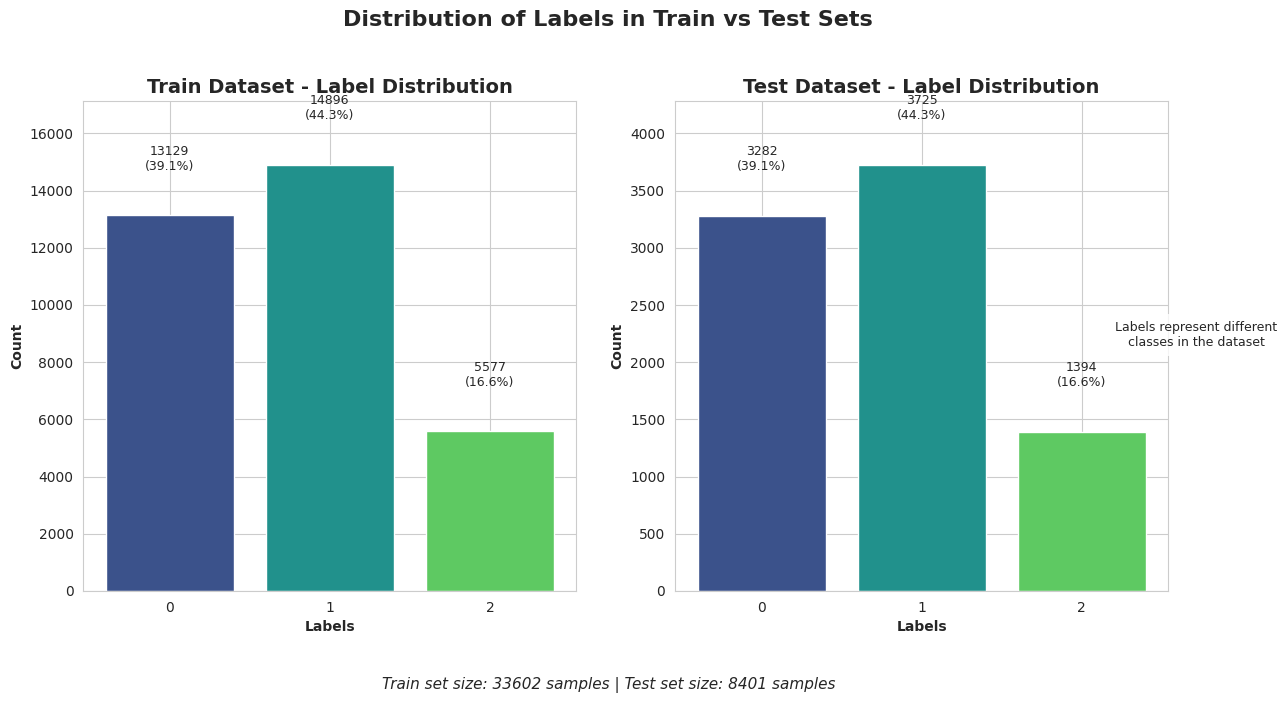

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Get label distributions
train_labels = df_train['label'].value_counts().sort_index()
test_labels = df_test['label'].value_counts().sort_index()

# Calculate percentages for annotations
train_total = len(df_train)
test_total = len(df_test)
train_percentages = (train_labels / train_total * 100).round(1)
test_percentages = (test_labels / test_total * 100).round(1)

# Create figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Color palette
colors = sns.color_palette("viridis", len(train_labels))

# Train dataset subplot
bars_train = axs[0].bar(train_labels.index.astype(str), train_labels.values, color=colors)
axs[0].set_xlabel('Labels', fontweight='bold')
axs[0].set_ylabel('Count', fontweight='bold')
axs[0].set_title('Train Dataset - Label Distribution', fontsize=14, fontweight='bold')
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_ylim(0, max(train_labels.values) * 1.15)  # Set y-limit with padding

# Add counts and percentages as annotations
for bar, count, percentage in zip(bars_train, train_labels.values, train_percentages):
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2., height + 0.1*max(train_labels.values),
                f'{count}\n({percentage}%)', ha='center', va='bottom', fontsize=9)

# Test dataset subplot
bars_test = axs[1].bar(test_labels.index.astype(str), test_labels.values, color=colors)
axs[1].set_xlabel('Labels', fontweight='bold')
axs[1].set_ylabel('Count', fontweight='bold')
axs[1].set_title('Test Dataset - Label Distribution', fontsize=14, fontweight='bold')
axs[1].tick_params(axis='x', rotation=0)
axs[1].set_ylim(0, max(test_labels.values) * 1.15)  # Set y-limit with padding

# Add counts and percentages as annotations
for bar, count, percentage in zip(bars_test, test_labels.values, test_percentages):
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2., height + 0.1*max(test_labels.values),
                f'{count}\n({percentage}%)', ha='center', va='bottom', fontsize=9)

# Add a figure title
fig.suptitle('Distribution of Labels in Train vs Test Sets', fontsize=16, fontweight='bold', y=0.98)

# Add some information about dataset sizes
plt.figtext(0.5, 0.01, f'Train set size: {train_total} samples | Test set size: {test_total} samples',
           ha='center', fontsize=11, fontstyle='italic')

# Ensure the bars are evenly distributed
for ax in axs:
    ax.set_xticks(np.arange(len(train_labels.index)))
    ax.set_xticklabels(train_labels.index)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, bottom=0.15, top=0.85)

# Add a legend if needed (if labels are numeric and not descriptive)
if train_labels.index.dtype != 'object':
    plt.figtext(0.92, 0.5, 'Labels represent different\nclasses in the dataset',
                fontsize=9, ha='center', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Display the plot
plt.show()

In [8]:
# Checking for missing values in the train dataset
train_na = df_train.isna().sum()
print('Train Dataset - Missing Values:')
print(train_na)

test_na = df_test.isna().sum()
print('\nTest Dataset - Missing Values:')
print(test_na)

Train Dataset - Missing Values:
text     0
label    0
dtype: int64

Test Dataset - Missing Values:
text     0
label    0
dtype: int64


In [9]:
df_train = df_train.dropna()
df_test = df_test.dropna()

# reset indexing
df_train = df_train.reset_index(drop=True)

In [10]:
print("Train Dataset Size:",df_train.shape )
print("Test Dataset Size:", df_test.shape)

Train Dataset Size: (33602, 2)
Test Dataset Size: (8401, 2)


In [11]:
# remove unwanted datas
print(df_train['label'].unique())
print(df_test['label'].unique())

valid_labels = [0, 1, 2]


# Filter train dataset
df_train = df_train.loc[df_train['label'].isin(valid_labels)]
df_train.loc[:, 'label'] = df_train['label'].astype(int)

# Filter test dataset
df_test = df_test.loc[df_test['label'].isin(valid_labels)]
df_test.loc[:, 'label'] = df_test['label'].astype(int)


[0 1 2]
[2 1 0]


In [12]:
print(df_train['label'])
print(df_test['label'])
df_train.head()

0        0
1        0
2        1
3        0
4        0
        ..
33597    0
33598    0
33599    0
33600    1
33601    0
Name: label, Length: 33602, dtype: int64
0       2
1       2
2       1
3       2
4       1
       ..
8396    0
8397    2
8398    2
8399    0
8400    1
Name: label, Length: 8401, dtype: int64


,text,label
0,कोभिड बारे हालसम्मको विकास क्रम,0
1,नेताहरु भ्रष्टाचार गर्छन जनताको छोराछोरी बिदेश...,0
2,गौतमबुद्द अन्तराष्ट्रिए क्रिकेट स्टडिएमको नराम...,1
3,दाइ हजुरको भिउज किन कम आज भोलि`,0
4,कोभिड नेपालमा जिडिपीको प्रतिशतसम्म क्षति हुनसक्ने,0


In [29]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')


In [31]:
df_train['text'] = df_train['text'].tolist()
print(type(df_train['text']))
print(df_train['text'].head())

<class 'pandas.core.series.Series'>
0                      कोभिड बारे हालसम्मको विकास क्रम
1    नेताहरु भ्रष्टाचार गर्छन जनताको छोराछोरी बिदेश...
2    गौतमबुद्द अन्तराष्ट्रिए क्रिकेट स्टडिएमको नराम...
3                      दाइ हजुरको भिउज किन कम आज भोलि`
4    कोभिड नेपालमा जिडिपीको प्रतिशतसम्म क्षति हुनसक्ने
Name: text, dtype: object


In [32]:
df_train['text'].apply(lambda x: len(tokenizer.tokenize(x))).describe()


,text
count,33602.000000
mean,30.863490
std,21.971628
min,1.000000
25%,15.000000
50%,25.000000
75%,43.000000
max,1428.000000


In [33]:
token_lengths = df_train['text'].apply(lambda x: len(tokenizer.tokenize(x)))
print((token_lengths > 128).mean())  # % of texts truncated


0.0013392059996428785


In [34]:
# Tokenize training data
train_tokens = tokenizer.batch_encode_plus(
    df_train['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

train_labels = label_encoder.fit_transform(df_train['label'])


In [16]:
print(train_labels)

[0 0 1 ... 0 1 0]


In [35]:
# Tokenize test data
test_tokens = tokenizer.batch_encode_plus(
    df_test['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors='pt'
)
test_labels = label_encoder.fit_transform(df_test['label'])

In [36]:
print(test_labels)

[2 2 1 ... 2 0 1]


In [37]:
# Clone the tensors safely
train_input_ids = train_tokens['input_ids'].clone().detach()
train_attention_masks = train_tokens['attention_mask'].clone().detach()
train_labels = torch.tensor(df_train['label'].values.astype(np.int64))

test_input_ids = test_tokens['input_ids'].clone().detach()
test_attention_masks = test_tokens['attention_mask'].clone().detach()
test_labels = torch.tensor(df_test['label'].values.astype(np.int64))


# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)


In [38]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [44]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3)
model.to(device)

batch_size = 16
learning_rate = 2e-5
epochs = 10

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

scaler = GradScaler()  # for mixed precision


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-44-27beb5bf6423>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision


In [48]:
from tqdm import tqdm
import torch
from torch.amp import autocast, GradScaler

# Initialize gradient scaler for mixed precision
scaler = GradScaler()

model.train()
loss_values = []
accuracy_values = []

for epoch in range(epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}')

    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        optimizer.zero_grad()

        # Updated autocast to use the new format
        with autocast('cuda', dtype=torch.float16):  # mixed precision
            outputs = model(**inputs)
            loss = outputs.loss

        total_loss += loss.item()

        predicted_labels = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predicted_labels == batch[2]).sum().item()
        total_predictions += batch[0].size(0)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions

    loss_values.append(average_loss)
    accuracy_values.append(accuracy)

    print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}')

Epoch 1: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=2]


Epoch 1: Average Loss: 0.6362 - Accuracy: 0.7407


Epoch 2: 100%|██████████| 2101/2101 [10:02<00:00,  3.49it/s, Training Loss=2.23]


Epoch 2: Average Loss: 0.5651 - Accuracy: 0.7765


Epoch 3: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=1.8]


Epoch 3: Average Loss: 0.5192 - Accuracy: 0.7987


Epoch 4: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.292]


Epoch 4: Average Loss: 0.5303 - Accuracy: 0.7908


Epoch 5: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.195]


Epoch 5: Average Loss: 0.4041 - Accuracy: 0.8490


Epoch 6: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.0353]


Epoch 6: Average Loss: 0.3485 - Accuracy: 0.8739


Epoch 7: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.441]


Epoch 7: Average Loss: 0.3620 - Accuracy: 0.8683


Epoch 8: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.0173]


Epoch 8: Average Loss: 0.2760 - Accuracy: 0.9052


Epoch 9: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.0602]


Epoch 9: Average Loss: 0.2993 - Accuracy: 0.8971


Epoch 10: 100%|██████████| 2101/2101 [10:01<00:00,  3.49it/s, Training Loss=0.00109]

Epoch 10: Average Loss: 0.2301 - Accuracy: 0.9330


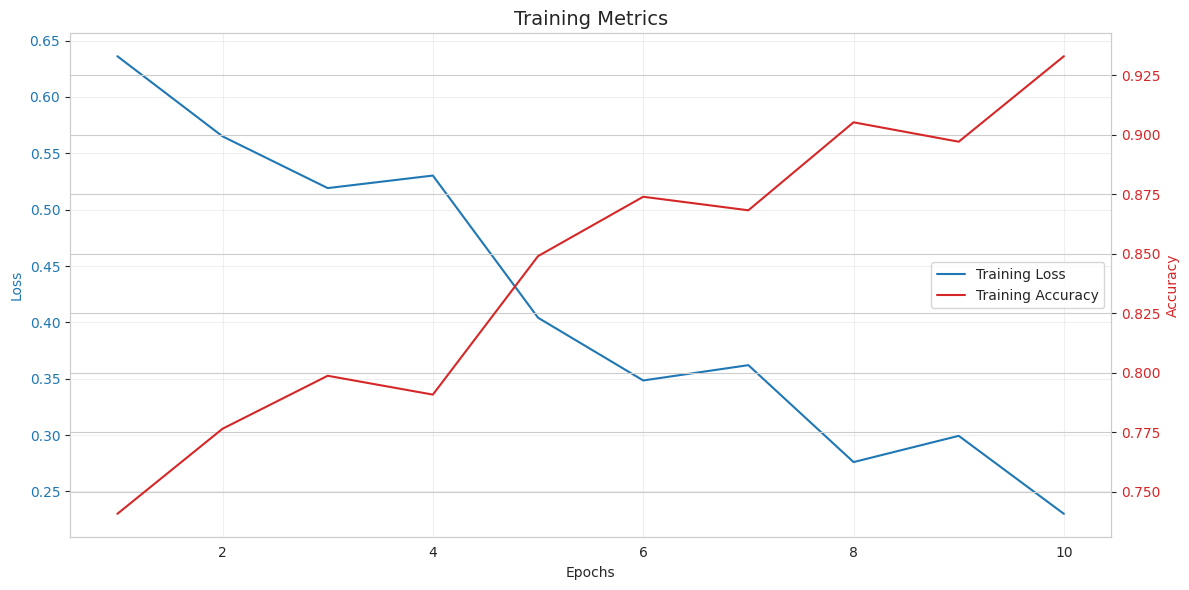

In [50]:
# First, let's ensure epochs is properly defined
# It looks like epochs might be a single value that needs to be converted to a range
# Assuming loss_values has 10 elements, we need to create matching epochs

# Check the actual number of training iterations
num_epochs = len(loss_values)

# Create proper epochs list (1-indexed)
epochs = list(range(1, num_epochs + 1))

# Now create the visualization with properly matched dimensions
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot loss on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss_values, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, accuracy_values, color=color, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Add grid for better readability
ax1.grid(True, alpha=0.3)

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.title('Training Metrics', fontsize=14)
plt.tight_layout()
plt.show()

In [55]:
import shutil

model_dir = os.path.join(root_dir, "model")

# Create the directory
os.makedirs(model_dir, exist_ok=True)

# Save the model
model.save_pretrained(model_dir)

# Save training metrics if available
# Make sure loss_values and accuracy_values exist before trying to save
if 'loss_values' in locals() and 'accuracy_values' in locals():
    import numpy as np

    # Get the actual number of epochs
    num_epochs = len(loss_values)
    epochs = list(range(1, num_epochs + 1))

    # Save metrics as numpy files
    np.save(os.path.join(model_dir, "loss_values.npy"), np.array(loss_values))
    np.save(os.path.join(model_dir, "accuracy_values.npy"), np.array(accuracy_values))

    # Create and save metrics visualization
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot loss on primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(epochs, loss_values, color=color, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Create secondary y-axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(epochs, accuracy_values, color=color, label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Training Metrics', fontsize=14)
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(model_dir, "training_metrics.png"), dpi=300)
    plt.close()

# Save tokenizer if available
try:
    tokenizer.save_pretrained(model_dir)
except:
    print("No tokenizer found or couldn't save it")

# Create a readme with training information
with open(os.path.join(model_dir, "README.txt"), "w") as f:
    f.write(f"Model saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("Model: Nepali Sentiment Analysis\n")
    if 'loss_values' in locals():
        f.write(f"Number of epochs: {len(loss_values)}\n")
        f.write(f"Final training loss: {loss_values[-1]}\n")
    if 'accuracy_values' in locals():
        f.write(f"Final training accuracy: {accuracy_values[-1]}\n")

# Create a zip file of the model directory
zip_path = os.path.join(root_dir, f"model")
shutil.make_archive(zip_path, 'zip', model_dir)

print(f"Model saved successfully to Google Drive at: {model_dir}")
print(f"Zip archive created at: {zip_path}.zip")

Model saved successfully to Google Drive at: /content/drive/MyDrive/nepali-sentiment-analysis/model
Zip archive created at: /content/drive/MyDrive/nepali-sentiment-analysis/model.zip


Evaluating: 100%|██████████| 526/526 [01:46<00:00,  4.93it/s]


<Figure size 1000x800 with 0 Axes>

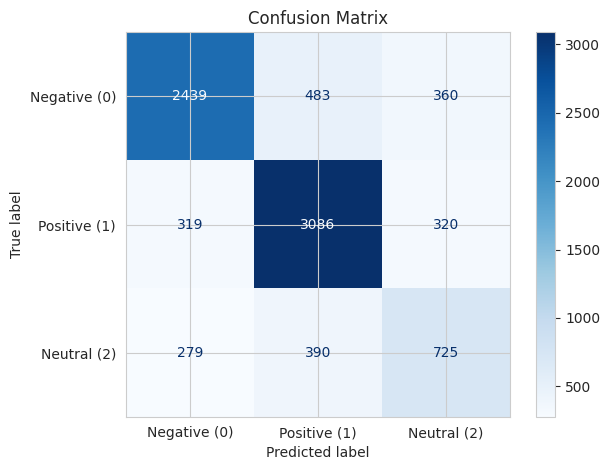

              precision    recall  f1-score   support

Negative (0)       0.80      0.74      0.77      3282
Positive (1)       0.78      0.83      0.80      3725
 Neutral (2)       0.52      0.52      0.52      1394

    accuracy                           0.74      8401
   macro avg       0.70      0.70      0.70      8401
weighted avg       0.74      0.74      0.74      8401



In [54]:
# Add a new cell after your model training and before saving the model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Set model to evaluation mode
model.eval()

# Create a dataloader for the test data
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# No gradient computation needed for evaluation
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)

        # Unpack the batch
        input_ids = batch[0]
        attention_mask = batch[1]
        true_labels = batch[2]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predicted labels
        predicted_labels = torch.argmax(logits, dim=1)

        # Move predictions and true labels to CPU
        predicted_labels = predicted_labels.cpu().numpy()
        true_labels = true_labels.cpu().numpy()

        # Append to lists
        all_predictions.extend(predicted_labels)
        all_true_labels.extend(true_labels)

# Calculate and display confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
class_names = ['Negative (0)', 'Positive (1)', 'Neutral (2)']  # Adjust based on your actual label mapping

# Create a figure for the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

In [63]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model_path = f"{root_dir}/model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

model.to(device)
model.eval()

# Nepali test sentences (general + COVID-related)
sentences = [
    # Political Satires
    "देश चलाउनु मकै भुटेजस्तो हो र?",
    "प्रधानमन्त्रीले फेरि गफ दिए – रेल अब छतमा गुड्नेछ!",
    "नेताले भन्या काम गर्छु भनेको सुनेको ५ वर्ष भयो!",
    "योजना घोषणा गरियो, कार्यान्वयन बुढाबुढीको कथा जस्तै!",
    "सरकारले एउटा फोटो खिचाउने परियोजना सफल बनायो।",
    "अब त नेताले पानीमा पुल बनाउँछु भन्न थालिसके।",
    "देशमा विकास नभए पनि भाषणको स्तर चर्किएको छ।",
    "नेताले जनताको भलोको लागि सोच्न थालेको देखिन्छ।",
    "सांसदहरूले पारिश्रमिक कटौतीको प्रस्ताव स्वीकृत गरे।",
    "हामी लोकतन्त्रमा बसिरहेका छौं, तर शासन चिनेको छैनौं।",
    # Sports
    "नेपालले भारतलाई हराउँदै ऐतिहासिक जित हासिल गर्‍यो।",
    "खेलाडीको मेहनतले देशको इज्जत बढाएको छ।",
    "नेपाली फुटबल अझै पनि २० वर्ष पछाडि छ।",
    "खेलको संरचना नहुँदा प्रतिभा हराइरहेका छन्।",
    "क्रिकेट टिमको नयाँ कोचले उत्साह ल्याएका छन्।",
    "आजको खेल बराबरीमा टुंगिएको छ।",
    "राष्ट्रिय खेलकुद सप्ताह औपचारिकतामै सीमित भयो।",
    "खेलाडीलाई तलबको व्यवस्था गरियो।",
    "सपोर्ट सिस्टम बलियो बनाउँदा मात्र खेल सुधारिन्छ।",
    "खेलकुद मन्त्रालय कहाँ हरायो?",
    # Healthcare (COVID)
    "खोप अभियान सफल भयो, जनताले राहत पाए।",
    "अस्पतालमा अक्सिजनको अभाव देखियो।",
    "कोरोनाले हामीलाई स्वास्थ्यको महत्व सिकायो।",
    "सरकारले निःशुल्क उपचारको घोषणा गर्‍यो।",
    "लकडाउनले मानसिक स्वास्थ्यमा असर पारेको छ।",
    "सार्वजनिक स्थलमा मास्क अनिवार्य गरिएको छ।",
    "ICU बेड नपाएर बिरामी बाटोमै मरे।",
    "स्वास्थ्यकर्मीको योगदान सराहनीय छ।",
    "कोरोनाको लहर फेरि आउँछ कि भन्ने डर छ।",
    "PCR रिपोर्ट आउनु अघि बिरामी निको भइसक्छ!",
    # International Politics
    "नेपाल–चीन सम्बन्ध बलियो बन्दै गएको छ।",
    "भारतसँगको सिमा विवाद अझै समाधान भएको छैन।",
    "संयुक्त राष्ट्रसंघको बैठकमा नेपालले शान्तिको कुरा गर्‍यो।",
    "विदेशी नेतासँग सेल्फी खिचेर देश चल्दैन!",
    "कूटनीतिक पहलमार्फत सहकार्यको ढोका खुलेको छ।",
    "अमेरिकाले सहयोगको आश्वासन दिएको छ।",
    "विदेश नीति अस्पष्ट हुँदा समस्या भएको छ।",
    "नयाँ राजदूतको नियुक्तिमा विवाद उठेको छ।",
    "भारत र चीनबीच नेपाल चिउरा भइसकेको छ।",
    "संसार बदलिँदै छ, हामी भाषणमै व्यस्त छौं।",
    # Education
    "अनलाइन शिक्षाले पहुँच नभएका विद्यार्थीलाई असर गर्‍यो।",
    "विद्यालय खुलेपछि पढाइमा सुधार देखिएको छ।",
    "SLC पास गर्नु अब टिकटकमा ट्रेन्ड हो!",
    "शिक्षकले इमान्दारीपूर्वक पढाउने वातावरण बनाएका छन्।",
    "पढाइ अब स्मार्टफोनको चार्जमा निर्भर छ।",
    "अनलाइन कक्षा जड्याँटजस्तै हुन्छ – कहिले आउँछ, कहिले जान्छ।",
    "निजी विद्यालयको शुल्क बढ्दो छ।",
    "शैक्षिक सुधारको लागि नयाँ नीतिहरू ल्याइएका छन्।",
    "परिक्षा स्थगित हुँदा विद्यार्थी अन्योलमा परे।",
    "शिक्षा प्रणालीमा केही सुधार देखिएको छ।",
    # random
    "मलाई यो फिल्म धेरै मन पर्यो।",
    "तपाईंको सेवा उत्कृष्ट छ।",
    "यो खाना स्वादिष्ट छैन।",
    "कार्यक्रम निकै निराशाजनक भयो।",
    "उनले दिएको जवाफ घमण्डपूर्ण थियो।",
    "कोरोना महामारीले धेरै परिवारहरूमा दुख ल्यायो।",
    "सरकारले अस्पतालमा निःशुल्क उपचार उपलब्ध गरायो।",
    "खोप पाएपछि सबै ढुक्क महसुस गरे।",
    "लकडाउनका कारण धेरै मानिस बेरोजगार भए।",
    "पछिल्लो समयमा केसहरू घट्दै गएका छन्।",
    "आजको मौसम रमाइलो छ।",
    "उसको व्यवहार नराम्रो लाग्यो।",
    "सडकको अवस्था पहिलेभन्दा सुधारिएको छ।",
    "बिजुली कटौतीले दिक्क बनायो।",
    "खेलाडीले उत्कृष्ट प्रदर्शन गरे।",
    "अस्पतालमा धेरै भीड थियो।",
    "विद्यालय खुलेको खबर राम्रो लाग्यो।",
    "कक्षा अनलाइन हुँदा धेरै समस्या भयो।",
    "उनको बोली सबैलाई मन पर्छ।",
    "परिक्षा रद्द हुँदा विद्यार्थीहरू अन्योलमा परे।",
    "अब मास्क लगाउनु अनिवार्य छैन।",
    "कोरोनाको तेस्रो लहरले डर बढायो।",
    "स्वास्थ्यकर्मीहरूले निरन्तर सेवा दिएका छन्।",
    "पढाइमा ध्यान केन्द्रित गर्न गाह्रो भयो।",
    "क्वारेन्टाइनमा बस्दा मानसिक दबाव बढ्यो।",
    "सरकारले स्वास्थ्य सामग्री बाँडेको छ।",
    "सामाजिक दूरी कायम राख्न सजिलो छैन।",
    "खोप अभियान सफल भयो।",
    "अस्पतालमा अक्सिजनको अभाव देखियो।",
    "अहिले स्थिति सामान्य हुँदै गएको देखिन्छ।"
]


# Sentiment label function
def sentiment_label(class_id):
    labels = {0: "Negative", 1: "Positive", 2: "Neutral"}
    return labels.get(class_id, "Unknown")

# Prediction function
def predict_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return sentiment_label(predicted_class)
# Collect data
table_data = []
for s in sentences:
    sentiment = predict_sentiment(s)
    table_data.append([s, sentiment])


In [61]:
!pip install tabulate

In [76]:
from tabulate import tabulate
# Get terminal width to auto-fit columns
# Get terminal width to auto-fit columns
terminal_width = shutil.get_terminal_size().columns

# Calculate column widths based on terminal width
sentence_width = int(terminal_width * 0.7)  # 70% for sentence
sentiment_width = int(terminal_width * 0.3)  # 30% for sentiment

# Ensure a minimum width for the sentiment column
min_sentiment_width = 15
sentiment_width = max(sentiment_width, min_sentiment_width)

# Adjust sentence width if sentiment width was increased
sentence_width = terminal_width - sentiment_width - 4  # Subtract padding

# Print as table
headers = ["Sentence", "Predicted Sentiment"]
col_widths = [sentence_width, sentiment_width]  # Set column widths


table = tabulate(
    table_data, headers=headers, tablefmt="grid", maxcolwidths=col_widths
)

print(table)



+-------------------------------------------+-----------------------+
| Sentence                                  | Predicted Sentiment   |
+===========================================+=======================+
| देश चलाउनु मकै भुटेजस्तो हो र?                     | Negative              |
+-------------------------------------------+-----------------------+
| प्रधानमन्त्रीले फेरि गफ दिए – रेल अब छतमा गुड्नेछ!      | Positive              |
+-------------------------------------------+-----------------------+
| नेताले भन्या काम गर्छु भनेको सुनेको ५ वर्ष भयो!          | Neutral               |
+-------------------------------------------+-----------------------+
| योजना घोषणा गरियो, कार्यान्वयन बुढाबुढीको कथा जस्तै!        | Negative              |
+-------------------------------------------+-----------------------+
| सरकारले एउटा फोटो खिचाउने परियोजना सफल बनायो।          | Positive              |
+-------------------------------------------+-----------------------+
| अब त नेताले पानीमा 